# Surface QUantitatIve pRecipitation Estimation (SQUIRE) for BNF

## Imports

In [1]:
import pyart
import matplotlib.pyplot as plt
import numpy as np
import glob
import act
from pathlib import Path


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [19]:
cmac_files = sorted(glob.glob("data/cmac/*"))
cmac_files

['data/cmac/bnfcsapr2cmacS3.c1.20250305.001313.nc',
 'data/cmac/bnfcsapr2cmacS3.c1.20250305.002316.nc',
 'data/cmac/bnfcsapr2cmacS3.c1.20250305.003319.nc',
 'data/cmac/bnfcsapr2cmacS3.c1.20250305.004321.nc',
 'data/cmac/bnfcsapr2cmacS3.c1.20250305.005324.nc',
 'data/cmac/bnfcsapr2cmacS3.c1.20250305.014010.nc']

## Load Data into Py-ART and Plot

In [6]:
radar = pyart.io.read(cmac_files[1])

In [21]:
for radar_file in cmac_files:
    radar = pyart.io.read(radar_file)
    print(radar.fields["rain_rate_A"]["data"].max())

0.0
0.0
0.0
0.0
0.0
0.0


In [24]:
import numpy as np
np.unique(radar.fields["rain_rate_A"]["data"])

masked_array(data=[0.0, --],
             mask=[False,  True],
       fill_value=1e+20)

(-100.0, 100.0)

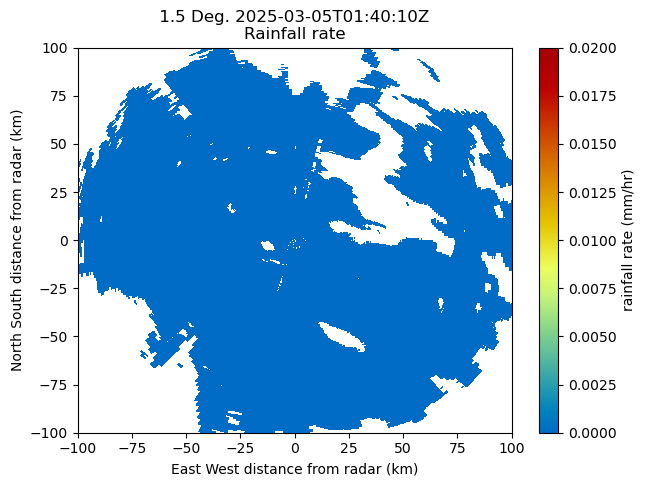

In [31]:
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=[7, 5])
ax = fig.add_subplot(111)
display.plot('rain_rate_A',
            0,
             vmin=0,
             vmax=0.02,
             cmap='HomeyerRainbow')
plt.xlim(-100, 100)
plt.ylim(-100, 100)

(-100.0, 100.0)

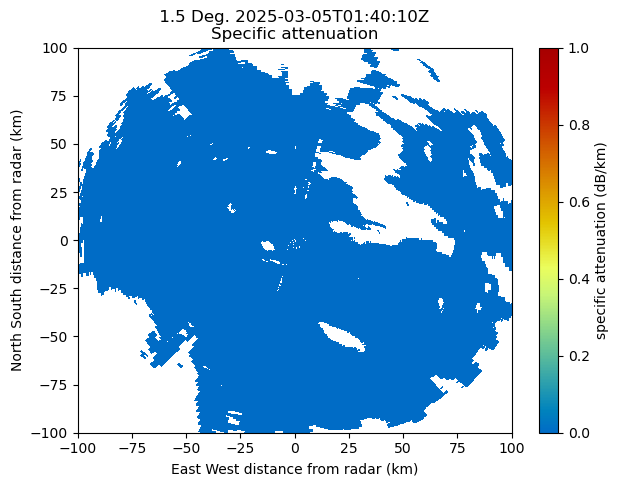

In [32]:
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=[7, 5])
ax = fig.add_subplot(111)
display.plot('specific_attenuation',
             0,
             cmap='HomeyerRainbow')
plt.xlim(-100, 100)
plt.ylim(-100, 100)

## Grid Using Nearest Neighbor Interpolation

### Setup a Helper Function and Configure our Grid

In [33]:
def compute_number_of_points(extent, resolution):
    """
    Create a helper function to determine number of points
    """
    return int((extent[1] - extent[0])/resolution) + 1

# Grid extents in meters
z_grid_limits = (250.,10_250.)
y_grid_limits = (-40_000.,40_000.)
x_grid_limits = (-40_000.,40_000.)

# Grid resolution in meters
grid_resolution = 500

Once we setup our interpolation, we can compute the number of points for each extent

In [34]:
x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)
z_grid_points = compute_number_of_points(z_grid_limits, grid_resolution)

print(z_grid_points,
      y_grid_points,
      x_grid_points)

21 161 161


### Create our Grid using `grid_from_radars`

In [35]:
grid = pyart.map.grid_from_radars(radar,
                                  grid_shape=(z_grid_points,
                                              y_grid_points,
                                              x_grid_points),
                                  grid_limits=(z_grid_limits,
                                               y_grid_limits,
                                               x_grid_limits),
                                  method='nearest',
                                  constant_roi=500
                                 )

## Visualize our Grid
We start by converting our grid to xarray

In [36]:
ds = grid.to_xarray()
ds

<xarray.Dataset> Size: 164MB
Dimensions:                                                (time: 1, z: 21,
                                                            y: 161, x: 161,
                                                            nradar: 1)
Coordinates: (12/16)
  * time                                                   (time) object 8B 2...
  * z                                                      (z) float64 168B 2...
    lat                                                    (y, x) float64 207kB ...
    lon                                                    (y, x) float64 207kB ...
  * y                                                      (y) float64 1kB -4...
  * x                                                      (x) float64 1kB -4...
    ...                                                     ...
    origin_altitude                                        (time) float32 4B ...
    radar_altitude                                         (nradar) float32 4B ...
    radar_latitude                                         (nradar) float32 4B ...
    radar_longitude                                        (nradar) float32 4B ...
    radar_time                                             (nradar) int64 8B 0
    radar_name                                             (nradar) <U1 4B ''
Dimensions without coordinates: nradar
Data variables: (12/57)
    differential_reflectivity_lag_1                        (time, z, y, x) float32 2MB ...
    specific_differential_attenuation                      (time, z, y, x) float64 4MB ...
    clutter_masked_velocity                                (time, z, y, x) float32 2MB ...
    mean_doppler_velocity                                  (time, z, y, x) float32 2MB ...
    copol_correlation_coeff                                (time, z, y, x) float32 2MB ...
    signal_to_noise_ratio                                  (time, z, y, x) float32 2MB ...
    ...                                                     ...
    filtered_corrected_specific_diff_phase                 (time, z, y, x) float64 4MB ...
    uncorrected_mean_doppler_velocity_h                    (time, z, y, x) float32 2MB ...
    corrected_differential_reflectivity                    (time, z, y, x) float64 4MB ...
    attenuation_corrected_reflectivity_h                   (time, z, y, x) float32 2MB ...
    cumulative_beam_blockage                               (time, z, y, x) float64 4MB ...
    ROI                                                    (time, z, y, x) float32 2MB ...
Attributes: (12/28)
    radar_name:            
    nradar:                1
    command_line:          cmaccsapr2 -s bnf -f S3 -b 20250305.000000 -e 2025...
    process_version:       vap-cmaccsapr2-0.0-0.dev0.dirty.el8
    dod_version:           csapr2cmac-c1-1.1
    input_datastreams:     bnfcsapr2cfrS3.a1 : 1.7 : 20250305.014010\nbnfsond...
    ...                    ...
    source:                Atmospheric Radiation Measurement (ARM) program C-...
    history:               created by user rjackson on machine cirrus47.ccs.o...
    volume_number:         0
    platform_type:         fixed
    instrument_type:       radar
    primary_axis:          axis_z

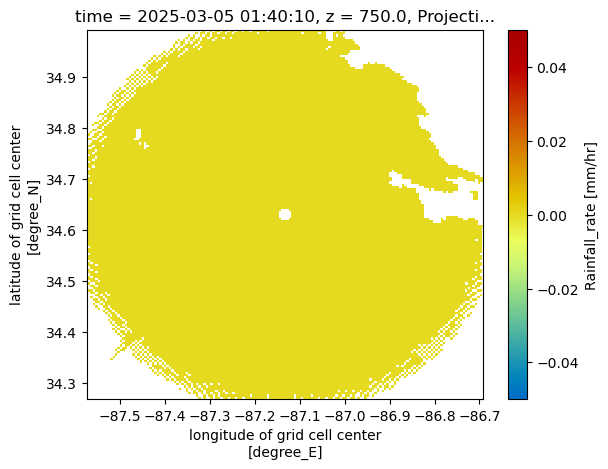

In [37]:
ds.rain_rate_A.isel(z=1).plot(x='lon',
                              y='lat',
                              cmap='HomeyerRainbow')

## Determine the Lowest Height in Each Column
We plotted the lowest level (500 m) in the plot above. It would be **more helpful** to have data from the lowest data point (lowest z) in each column (across time, latitude, and longitude)

We start first by creating a new field in our dataset, `height_expanded`, which is a four-dimensional (time, z, x, y) vertical coordinate, with nan values where we have missing snow rate values.

In [38]:
ds["height_expanded"] = (ds.z * (ds.rain_rate_A/ds.rain_rate_A)).fillna(10_000)

Next, we find the index of the lowest value in this column, using the `.argmin` method, looking over the column (z)

In [39]:
min_index = ds.height_expanded.argmin(dim='z',
                                      skipna=True)

Here is a plot of the lowest value height in the column for our domain:

**Notice how some values are the top of the column - 5000 m, whereas some of the values are close lowest vertical level, 500 m

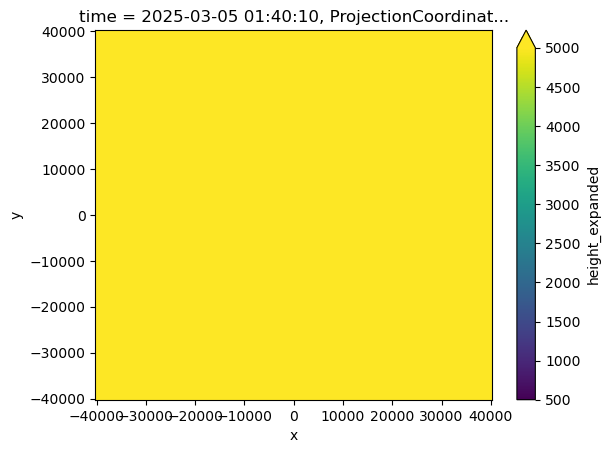

In [40]:
ds.height_expanded.isel(z=min_index).plot(vmin=500,
                                          vmax=5000);

### Apply this to our snow fields
We first check for snow fields in our dataset, by using the following list comprehension line:

In [41]:
snow_fields = [var for var in list(ds.variables) if "rain" in var]
snow_fields

['rain_rate_A']

Next, we subset our dataset for only these fields and select our lowest z value (using the index we built before)

In [42]:
subset_ds = ds[snow_fields].isel(z=min_index)

### Visualize our closest-to-ground snow value
Now that we have the lowest vertical level in each column, let's plot our revised maps, which only have dimensions:
- time
- latitude
- longitude

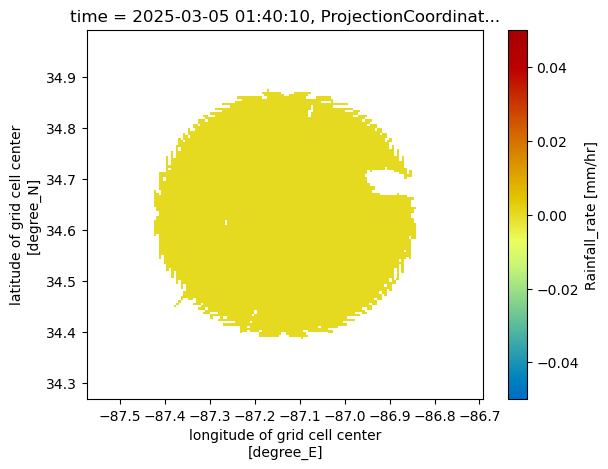

In [44]:
for snow_field in snow_fields:
    subset_ds[snow_field].plot(x='lon',
                               y='lat',
                               cmap='HomeyerRainbow')
    plt.show()
    plt.close()

## Wrap this Up into a Function
Now that we have the full pipeline, let's wrap this into a function!

In [12]:
def grid_radar(file,
               x_grid_limits=(-20_000.,20_000.),
               y_grid_limits=(-20_000.,20_000.),
               z_grid_limits = (500.,5_000.),
               grid_resolution = 250,
               
               ):
    """
    Grid the radar using some provided parameters
    """
    
    radar = pyart.io.read(file)
    
    x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
    y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)
    z_grid_points = compute_number_of_points(z_grid_limits, grid_resolution)
    
    grid = pyart.map.grid_from_radars(radar,
                                      grid_shape=(z_grid_points,
                                                  y_grid_points,
                                                  x_grid_points),
                                      grid_limits=(z_grid_limits,
                                                   y_grid_limits,
                                                   x_grid_limits),
                                      method='nearest'
                                     )
    return grid.to_xarray()

def subset_lowest_vertical_level(ds, additional_fields=["corrected_reflectivity"]):
    """
    Filter the dataset based on the lowest vertical level
    """
    snow_fields = [var for var in list(ds.variables) if "snow" in var] + additional_fields
    
    # Create a new 4-d height field
    ds["height_expanded"] = (ds.z * (ds[snow_fields[0]]/ds[snow_fields[0]])).fillna(5_000)
    
    # Find the minimum height index
    min_index = ds.height_expanded.argmin(dim='z',
                                          skipna=True)
    
    # Subset our snow fields based on this new index
    subset_ds = ds[snow_fields].isel(z=min_index)
    
    return subset_ds

## Loop Through and Apply this Workflow
Now that we have our helper functions, we can apply our workflow to each file.

In [14]:
for file in files:
    ds = grid_radar(file)
    out_ds = subset_lowest_vertical_level(ds)
    
    # Create an output path
    out_path = f"gridded-for-dan/{Path(file).stem}.gridded.nc"
    out_ds.to_netcdf(out_path)
    print("Finished writing:", out_path)

Finished writing: gridded-for-dan/gucxprecipradarcmacM1.c1.20220314-030920.gridded.nc
Finished writing: gridded-for-dan/gucxprecipradarcmacM1.c1.20220314-032520.gridded.nc
Finished writing: gridded-for-dan/gucxprecipradarcmacM1.c1.20220314-033040.gridded.nc
Finished writing: gridded-for-dan/gucxprecipradarcmacM1.c1.20220314-033600.gridded.nc
Finished writing: gridded-for-dan/gucxprecipradarcmacM1.c1.20220314-034120.gridded.nc
Finished writing: gridded-for-dan/gucxprecipradarcmacM1.c1.20220314-034640.gridded.nc
Finished writing: gridded-for-dan/gucxprecipradarcmacM1.c1.20220314-035720.gridded.nc
